## Importing Packages

In [ ]:
#Data management
import pandas as pd
import numpy as np
np.random.seed(0)
#from pandas_profiling import ProfileReport

#TextBlob Features
from textblob import TextBlob

#Plotting
import matplotlib.pyplot as plt

#SciKit-Learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#nltk
import nltk
from nltk.corpus import stopwords
#nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
#nltk.download('wordnet')

#Tensorflow / Keras
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

#Test
from collections import Counter

## Importing Data

In [ ]:
#Training Data
path = "/content/facebook_training.csv"
train_df = pd.read_csv(path, names=["Faceboob_ID", "Entity", "Sentiment", "Review_Content"])

#Test Data (Not to be used until the full model has been trained)
test_path = "/content/facebook_validation.csv"
test_df = pd.read_csv(test_path, names=["Facebook_ID", "Entity", "Sentiment", "Review_Content"])

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Dropping NA Values

In [ ]:
train_df = train_df.dropna()
test_df = test_df.dropna()

In [ ]:
train_df.shape

(73996, 4)

## Subsetting Data

In [ ]:
df = train_df.sample(frac=0.1)
df.reset_index(drop=True, inplace=True)

## Data Exploration

In [ ]:
#See overall information about the data frame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7400 entries, 0 to 7399
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Faceboob_ID     7400 non-null   int64 
 1   Entity          7400 non-null   object
 2   Sentiment       7400 non-null   object
 3   Review_Content  7400 non-null   object
dtypes: int64(1), object(3)
memory usage: 231.4+ KB


In [ ]:
#Display a few entries
df.head()

,Faceboob_ID,Entity,Sentiment,Review_Content
0,2535,Borderlands,Negative,@ Borderlands. Can we get a big fix please? I'...
1,11073,TomClancysGhostRecon,Negative,@GhostRecon You call 1.1.0 an update. You're h...
2,3024,Dota2,Neutral,I'm excited to watch the EU's closed qualifyin...
3,6719,Fortnite,Negative,"anyways but my fortnite here,, im annoyed."
4,1533,Battlefield,Negative,Collateral with the revolver is so satisfying....


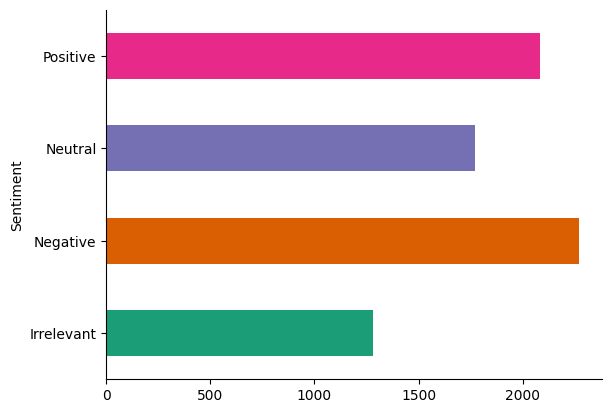

In [ ]:
# @title Sentiment
#visualizing horizontal bar plot across different categories of sentiments in a dataframe
from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('Sentiment').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

## Checking Balance of the Data in Output Categories

<BarContainer object of 4 artists>

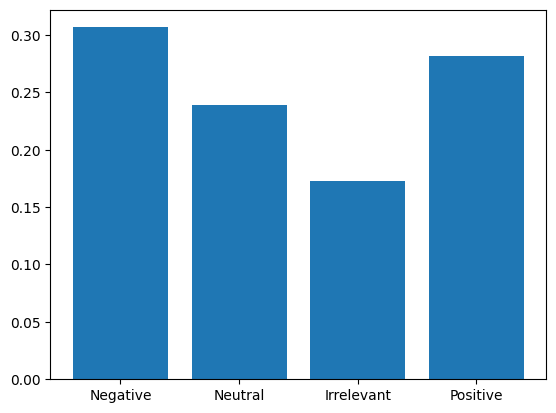

In [ ]:
#Checking balance of target classes
#Again checking the distribution of sentiments across the data frame using bar plot
sentiments = list(df["Sentiment"].unique())

sentiment_nums = [len(df[df["Sentiment"] == sentiment]) / len(df) for sentiment in sentiments]

plt.bar(sentiments, sentiment_nums)

## Labels to Indexes (and Back Again)


In [ ]:
#Define the indexing for each possible label in a dictionary
#using lambda function to Map sentiment names to numerical indices.
class_to_index = {"Neutral":0, "Irrelevant":1, "Negative":2, "Positive": 3}

#Creates a reverse dictionary
index_to_class = dict((v,k) for k, v in class_to_index.items())

#Creates lambda functions, applying the appropriate dictionary
names_to_ids = lambda n: np.array([class_to_index.get(x) for x in n])
ids_to_names = lambda n: np.array([index_to_class.get(x) for x in n])

In [ ]:
#Test each function
print(names_to_ids(["Positive", "Negative", "Irrelevant", "Neutral"]))
print(ids_to_names([0,1,2,3]))

[3 2 1 0]
['Neutral' 'Irrelevant' 'Negative' 'Positive']


In [ ]:
#Convert the "Sentiment" column into indexes
df["Sentiment"] = names_to_ids(df["Sentiment"])

In [ ]:
df.head()

,Faceboob_ID,Entity,Sentiment,Review_Content
0,2535,Borderlands,2,@ Borderlands. Can we get a big fix please? I'...
1,11073,TomClancysGhostRecon,2,@GhostRecon You call 1.1.0 an update. You're h...
2,3024,Dota2,0,I'm excited to watch the EU's closed qualifyin...
3,6719,Fortnite,2,"anyways but my fortnite here,, im annoyed."
4,1533,Battlefield,2,Collateral with the revolver is so satisfying....


## NLP Data Enrichment

In [ ]:
#Tokenize, lemmatize, remove stopwords, and join.
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
def remove_stopwords(ls):
    #Lemmatises, then removes stop words
    ls = [lemmatiser.lemmatize(word) for word in ls if word not in (stop_english) and (word.isalpha())]

    #Joins the words back into a single string
    ls = " ".join(ls)
    return ls

#Splits each string into a list of words
df["Review_Content_Split"] = df["Review_Content"].apply(word_tokenize)

#Applies the above function to each entry in the DataFrame
lemmatiser = WordNetLemmatizer()
stop_english = Counter(stopwords.words()) #Here we use a Counter dictionary on the cached
                                          # list of stop words for a huge speed-up
df["Review_Content_Split"] = df["Review_Content_Split"].apply(remove_stopwords)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
df.head()

,Faceboob_ID,Entity,Sentiment,Review_Content,Review_Content_Split
0,2535,Borderlands,2,@ Borderlands. Can we get a big fix please? I'...,Borderlands Can big fix I reset entire factory...
1,11073,TomClancysGhostRecon,2,@GhostRecon You call 1.1.0 an update. You're h...,GhostRecon You call update You laugh stay conn...
2,3024,Dota2,0,I'm excited to watch the EU's closed qualifyin...,I excited watch EU closed qualifying match EU ...
3,6719,Fortnite,2,"anyways but my fortnite here,, im annoyed.",fortnite annoyed
4,1533,Battlefield,2,Collateral with the revolver is so satisfying....,Collateral revolver unk


## Tokenisation

In [ ]:
#Define the Tokeniser
tokeniser = Tokenizer(num_words=10000, lower=True)

#Create the corpus by finding the most common
tokeniser.fit_on_texts(df["Review_Content_Split"])

In [ ]:
#Tokenise our column of edited Tweet content
review_tokens = tokeniser.texts_to_sequences(list(df["Review_Content_Split"]))

In [ ]:
#Pad these sequences to make them the same length
review_tokens = pad_sequences(review_tokens, truncating = 'post', padding='post', maxlen=50)

In [ ]:
review_tokens.shape

(7400, 50)

## Final Data Preparation

In [ ]:
#Remove dependent variable
y = df["Sentiment"]

#Drop all non-useful columns
df = pd.DataFrame(review_tokens)

In [ ]:
#Display final shape
df.shape

(7400, 50)

## Test-Train Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=1)

In [ ]:
#Sequential model with Long Short-Term Memory layers.
model = tf.keras.models.Sequential([
tf.keras.layers.Embedding(10000,16,input_length=50),
tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
tf.keras.layers.Dense(4, activation='softmax')
])
model.compile(
     loss='sparse_categorical_crossentropy',
     optimizer='adam',
     metrics=['accuracy']
)

## Training

In [ ]:
h = model.fit(
     X_train, y_train,
     validation_data=(X_test, y_test),
     epochs=15,
     callbacks=[tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=5)]
)

Epoch 1/15
185/185 [==============================] - 14s 46ms/step - loss: 1.3352 - accuracy: 0.3525 - val_loss: 1.2390 - val_accuracy: 0.4385
Epoch 2/15
185/185 [==============================] - 8s 41ms/step - loss: 1.0891 - accuracy: 0.5215 - val_loss: 1.1503 - val_accuracy: 0.5054
Epoch 3/15
185/185 [==============================] - 6s 31ms/step - loss: 0.7658 - accuracy: 0.6988 - val_loss: 1.1819 - val_accuracy: 0.5419
Epoch 4/15
185/185 [==============================] - 7s 36ms/step - loss: 0.5087 - accuracy: 0.8186 - val_loss: 1.2863 - val_accuracy: 0.5385
Epoch 5/15
185/185 [==============================] - 5s 29ms/step - loss: 0.3552 - accuracy: 0.8748 - val_loss: 1.3930 - val_accuracy: 0.5703
Epoch 6/15
185/185 [==============================] - 7s 35ms/step - loss: 0.2717 - accuracy: 0.9054 - val_loss: 1.5701 - val_accuracy: 0.5682
Epoch 7/15
185/185 [==============================] - 6s 30ms/step - loss: 0.2280 - accuracy: 0.9206 - val_loss: 1.5678 - val_accuracy: 0.555

## Model Evaluation


In [ ]:
#Generate predictions
y_pred = np.argmax(model.predict(X_test), axis=1)

#Assign labels to predictions and test data
y_pred_labels = ids_to_names(y_pred)
y_test_labels = ids_to_names(y_test)

47/47 [==============================] - 2s 9ms/step


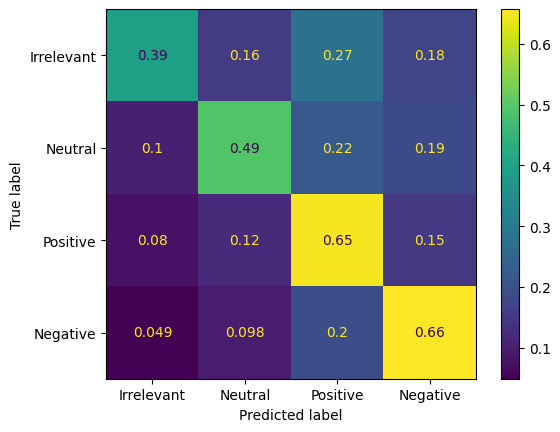

In [ ]:
#overall measure of performance of a classification model by plotting a normalized confusion matrix
#making a confusion matrix for evaluating the performance of a classification model.
y_unique = list(set(y_test_labels))
cm = confusion_matrix(y_test_labels, y_pred_labels, labels = y_unique, normalize='true')

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y_unique)
disp.plot()

## Training with Full Dataset

In [ ]:
#Use the full dataset!
df = train_df

## Basic Data Enrichment

In [ ]:
#Convert the "Sentiment" column into indexes

##Train
df["Sentiment"] = names_to_ids(df["Sentiment"])
y = df["Sentiment"]

##Test
test_df["Sentiment"] = names_to_ids(test_df["Sentiment"])
y_test = test_df["Sentiment"]

## NLP Data Enrichment

In [ ]:
#Removing stopwords and lemmatising

##Train
#Splits each string into a list of words
df["Review_Content_Split"] = df["Review_Content"].apply(word_tokenize)

#Applies the above function to each entry in the DataFrame
lemmatiser = WordNetLemmatizer()
stop_english = Counter(stopwords.words()) #Here we use a Counter dictionary on the cached
                                          # list of stop words for a huge speed-up
df["Review_Content_Split"] = df["Review_Content_Split"].apply(remove_stopwords)

##Test
test_df["Review_Content_Split"] = test_df["Review_Content"].apply(word_tokenize)

test_df["Review_Content_Split"] = test_df["Review_Content_Split"].apply(remove_stopwords)

In [ ]:
#Tokenisation

#Define the Tokeniser
tokeniser = Tokenizer(num_words=10000, lower=True)

#Create the corpus by finding the most common
tokeniser.fit_on_texts(df["Review_Content_Split"])

##Train
#Tokenise our column of edited Tweet content
review_tokens = tokeniser.texts_to_sequences(list(df["Review_Content_Split"]))
review_tokens = pad_sequences(review_tokens, truncating = 'post', padding='post', maxlen=50)

##Test
#Tokenise our column of edited Tweet content
review_tokens_test = tokeniser.texts_to_matrix(list(test_df["Review_Content_Split"]))
review_tokens_test = pad_sequences(review_tokens_test, truncating = 'post', padding='post', maxlen=50)

In [ ]:
#Final prep

##Train
#Drop all non-useful columns
full_df = pd.DataFrame(review_tokens)

##Test
full_test_df = pd.DataFrame(review_tokens_test)

## Model Definition and Training

This time, we train with all of the available training data

In [ ]:
#Sequential model with stacked Bidirectional LSTM layers.
model = tf.keras.models.Sequential([
tf.keras.layers.Embedding(10000,16,input_length=50),
tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
tf.keras.layers.Dense(4, activation='softmax')
])

model.compile(
     loss='sparse_categorical_crossentropy',
     optimizer='adam',
     metrics=['accuracy']
)

In [ ]:
#Train model on data with validation.
h = model.fit(
     full_df, y,
     validation_data=(full_test_df, y_test),
     epochs=30,
     callbacks=[tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=5)]
)

Epoch 1/30
2313/2313 [==============================] - 100s 41ms/step - loss: 0.8967 - accuracy: 0.6340 - val_loss: 1.4254 - val_accuracy: 0.2770
Epoch 2/30
2313/2313 [==============================] - 92s 40ms/step - loss: 0.5275 - accuracy: 0.8029 - val_loss: 1.3796 - val_accuracy: 0.3140
Epoch 3/30
2313/2313 [==============================] - 89s 38ms/step - loss: 0.4091 - accuracy: 0.8476 - val_loss: 1.3975 - val_accuracy: 0.2770
Epoch 4/30
2313/2313 [==============================] - 90s 39ms/step - loss: 0.3502 - accuracy: 0.8680 - val_loss: 1.3925 - val_accuracy: 0.2740
Epoch 5/30
2313/2313 [==============================] - 88s 38ms/step - loss: 0.3115 - accuracy: 0.8819 - val_loss: 1.4029 - val_accuracy: 0.2800
Epoch 6/30
2313/2313 [==============================] - 87s 38ms/step - loss: 0.2849 - accuracy: 0.8911 - val_loss: 1.3918 - val_accuracy: 0.2810
Epoch 7/30
2313/2313 [==============================] - 89s 39ms/step - loss: 0.2622 - accuracy: 0.8986 - val_loss: 1.3794 

## Final Model Evaluation

In [ ]:
#Generate predictions
y_pred = np.argmax(model.predict(full_test_df), axis=1)

#Assign labels to predictions and test data
y_pred_labels = ids_to_names(y_pred)
y_test_labels = ids_to_names(y_test)

32/32 [==============================] - 1s 9ms/step


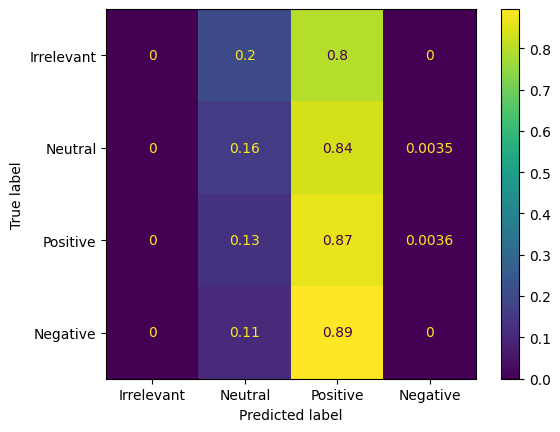

In [ ]:
y_unique = list(set(y_test_labels))
cm = confusion_matrix(y_test_labels, y_pred_labels, labels = y_unique, normalize='true')

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y_unique)
disp.plot()

In [ ]:
#To see the final accuracy
accuracy_score(y_test, y_pred)

0.285